# Practice Session 09: Forecasting

In this session we will do some time series forecasting on a weather-related time series, which contains temperature, precipitation, and wind speed data for the Barcelona airport.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Àlex Montoya Pérez</font>

E-mail: <font color="blue">alex.montoya.01@estudiant.upf.edu</font>

Date: <font color="blue">22/11/2023</font>

<font size="+2" color="blue">Additional results: cross correlations</font>

# **Google Colaboratory Setup & Imports**

In order to develop this laboratory, I used Google Colaboratory, since I have worked with different files I had to set up the environment as follows:


1.   Importing the drive module from the google.colab package.
2.   Mounting the Google Drive at the specified path (/content/drive).
3.   Changing the current working directory to the directory where I have all needed data /content/drive/MyDrive/MineriaDadesMasives/Labs/.

Verify that we are in the correct directory:


4.   Printing the current working directory path using !pwd.
5.   Listing the contents of the current directory using !ls.

In [69]:
from google.colab import drive
drive.mount('/content/drive')
#Here is how to change current working directory
#By default the current working directory is /content
%cd /content/drive/MyDrive/MineriaDadesMasives/Labs/data
#Print path and content of the current directory
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MineriaDadesMasives/Labs/data
/content/drive/MyDrive/MineriaDadesMasives/Labs/data
aemet-barcelona-airport-2016-2022.json	instacart		README.md
annthyroid.csv				movie_dialog_corpus	re_dataset.csv
BreadBasket_DMS.csv			movielens-1M		services_purchased.csv
covid-lockdown-catalonia		movielens-25M-filtered	users.dat
DCEP-reports-en.txt.gz			other_datasets
device_db.csv				products.csv


In [70]:
import io
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 1. Dataset

In [71]:
# LEAVE AS-IS

INPUT_FILE = "aemet-barcelona-airport-2016-2022.json"
weather = pd.read_json(INPUT_FILE)

weather.head(5)

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",11:50,99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",11:50,13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",08:10,20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",10:30,25.0,"3,3","6,7",23:20,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",14:00,35.0,"3,1","6,4",02:00,NaN,NaN,NaN,NaN,NaN


In [72]:
# LEAVE AS-IS

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "time_temp_min",
  "horatmax" : "time_temp_max",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "time_windspeed_gusts",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "time_pressure_max",
  "presMin" : "pressure_min",
  "horaPresMin" : "time_pressure_min"
}

##Rename column names

In [73]:
#Rename each column
weather = weather.rename(COLUMN_NAMES, axis = 'columns')

#print the first 5 rows of the data
display(weather.head(5))

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,time_windspeed_gusts,sun,pressure_max,time_pressure_max,pressure_min,time_pressure_min
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",11:50,99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",11:50,13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",08:10,20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",10:30,25.0,"3,3","6,7",23:20,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",14:00,35.0,"3,1","6,4",02:00,NaN,NaN,NaN,NaN,NaN


##  Drop the station_num, station_name, station_province, station_altitude, and time_* columns,

In [74]:
#Drop some columns that are useless for our study.
weather = weather.drop(["station_num", "station_name", "station_province", "station_altitude", "time_pressure_max", "time_pressure_min", "time_windspeed_gusts", "time_temp_max", "time_temp_min"], axis = 1)

#print the first 5 rows of the data
display(weather.head(5))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",NaN,NaN,NaN


##  Convert numbers with commas

In [75]:
def str_commas_to_float(value):
    #If the input is an string we will check whether it is a number or not, else we will just return the input.
    if(isinstance(value, str)):
        #Firstly, we split the value on , and . The 2 possible alternatives to see if there's a number
        splitted = value.split(',')
        dot_split = value.split('.')
        #If len > 1 then the input had a ,
        if len(splitted) > 1:
            for split in splitted:
                #If both sides of the , are numbers, then replace the , for a . and return the floated value
                if(split.isnumeric()):
                    return float(value.replace(',','.'))
                    break
        #If the value is string but numeric or both sides of the . are numeric return the floated value
        elif value.isnumeric() or (dot_split[0].isnumeric() and dot_split[1].isnumeric()):
            return float(value)
        #If input = "Ip" return 0
        elif value == 'Ip':
            return float(0)
        #Else, we will be in the case input is not a number and return nan.
        else:
            return np.nan
    else:
        return value


### Tests

In [76]:
print(str_commas_to_float(""))
assert np.isnan(str_commas_to_float(""))
print(str_commas_to_float("Varias"))
assert np.isnan(str_commas_to_float("Varias"))
print(str_commas_to_float("06:30"))
assert np.isnan(str_commas_to_float("06:30"))
print(str_commas_to_float("0,0"))
assert (str_commas_to_float("0,0")) == 0
print(str_commas_to_float("Ip"))
assert (str_commas_to_float("Ip")) == 0
print(str_commas_to_float("13,5"))
assert (str_commas_to_float("13,5")) == 13.5
print(str_commas_to_float("13"))
assert (str_commas_to_float("13")) == 13

nan
nan
nan
0.0
0.0
13.5
13.0


In [77]:
# Apply this function to columns 'temp_min', 'temp_max', 'temp_avg', 'rainfall', 'windspeed_dir', 'windspeed_avg', 'windspeed_gusts', 'sun', 'pressure_min', 'pressure_max'.
#To apply function f to column c of dataframe df, we use df[c] = df[c].apply(f).

weather[ 'temp_min'] = weather[ 'temp_min'].apply(str_commas_to_float)
weather['temp_max'] = weather['temp_max'].apply(str_commas_to_float)
weather['temp_avg'] = weather['temp_avg'].apply(str_commas_to_float)
weather['rainfall'] = weather['rainfall'].apply(str_commas_to_float)
weather['windspeed_dir'] = weather['windspeed_dir'].apply(str_commas_to_float)
weather['windspeed_avg'] = weather['windspeed_avg'].apply(str_commas_to_float)
weather['windspeed_gusts'] = weather['windspeed_gusts'].apply(str_commas_to_float)
weather['sun'] = weather['sun'].apply(str_commas_to_float)
weather['pressure_min'] = weather['pressure_min'].apply(str_commas_to_float)
weather['pressure_max'] = weather['pressure_max'].apply(str_commas_to_float)

## Plot Comparation

In [78]:
# LEAVE AS-IS

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
weather.head(3)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN


In [79]:
# LEAVE AS-IS

# Configure font sizes
plt.rc('font', size=10)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

In [80]:
# LEAVE AS-IS

# Plot function
def plot(df, column, xlabel='Date', ylabel=''):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[column],
                  fmt='.-', color='black')

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def plot_min_avg_max(df, min_column='temp_min', avg_column='temp_avg', max_column='temp_max', xlabel='Date', ylabel='Daily temperature [C]'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[avg_column],
                  fmt='.-', color='black', label='Average')
    plt.fill_between(df.index, df[min_column], df[max_column],
                     color='lightgray')
    plt.legend()

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

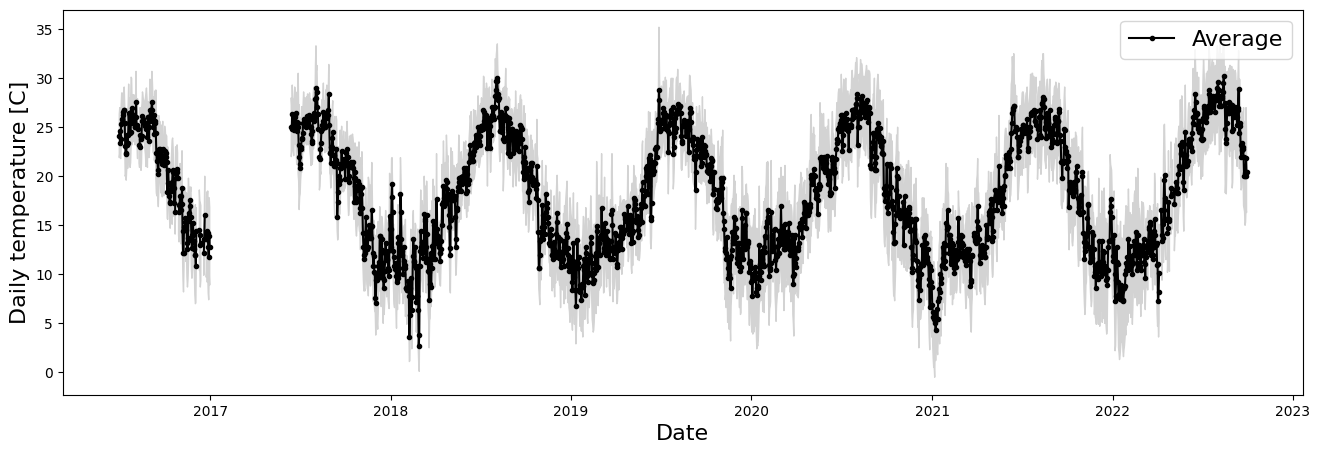

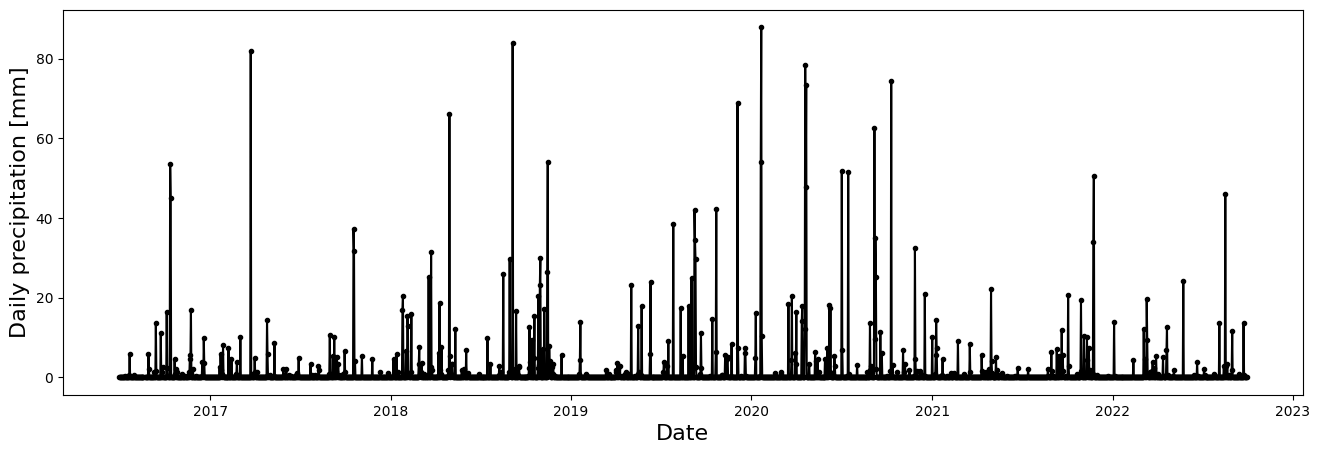

In [81]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather.tail(7*365)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Daily precipitation [mm]")

**Is seasonality clear in both of them, on one of them?**

In the initial scenario, the distinction between summer and winter is unmistakably evident, with consistently elevated temperatures occurring during a specific period each year. Similarly, low temperatures are consistently observed during the same timeframe. However, in the second scenario, the clarity diminishes as there are instances of unexpected precipitation, such as during the midpoints of 2017-2018 and 2018-2019. On the contrary, the year 2021-2022 lacks precipitation during the middle of the year, contributing to a less predictable pattern.

# 1. Smooth this series


## 1.1 Smooth the series using moving averages

## Moving Average

In [82]:
def moving_average(df, window_size):
    smoothed = pd.DataFrame(columns=df.columns)

    for i in range(len(df)):
        if i - window_size < 0:
            data = df.iloc[0:i + 1]
        else:
            data = df.iloc[i - window_size + 1:i + 1]

        # Append the mean of the data to the smoothed dataframe
        smoothed = pd.concat([smoothed, data.mean(axis=0).to_frame().T], ignore_index=True)

    smoothed.index = df.index
    return smoothed


In [83]:
# LEAVE AS-IS

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.100000,0.000000,21.900000,26.300000,99.000000,3.100000,5.800000,NaN,NaN,NaN
2016-07-02,24.350000,0.000000,22.100000,26.650000,56.000000,3.350000,6.650000,NaN,NaN,NaN
2016-07-03,24.033333,0.000000,22.033333,26.066667,44.000000,3.633333,7.400000,NaN,NaN,NaN
2016-07-04,23.975000,0.000000,21.975000,26.025000,39.250000,3.550000,7.225000,NaN,NaN,NaN
2016-07-05,24.240000,0.000000,22.220000,26.300000,38.400000,3.460000,7.060000,NaN,NaN,NaN
2016-07-06,24.500000,0.000000,22.366667,26.666667,35.333333,3.716667,7.833333,NaN,NaN,NaN
2016-07-07,24.628571,0.000000,22.557143,26.728571,44.428571,3.742857,8.185714,NaN,NaN,NaN
2016-07-08,24.928571,0.014286,22.857143,27.028571,33.571429,3.657143,8.871429,NaN,NaN,NaN
2016-07-09,25.214286,0.014286,23.214286,27.242857,34.285714,3.585714,8.757143,NaN,NaN,NaN


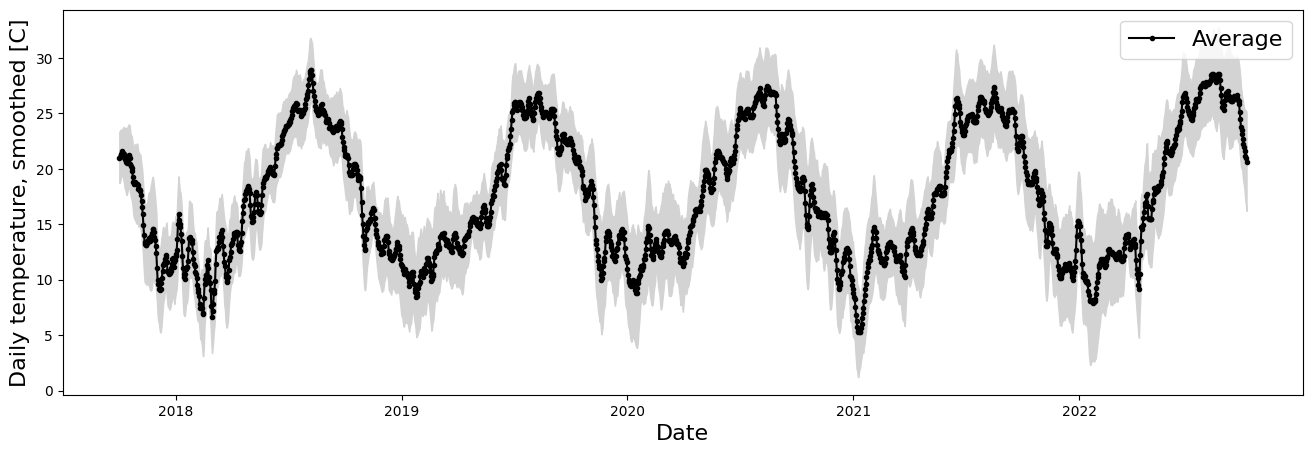

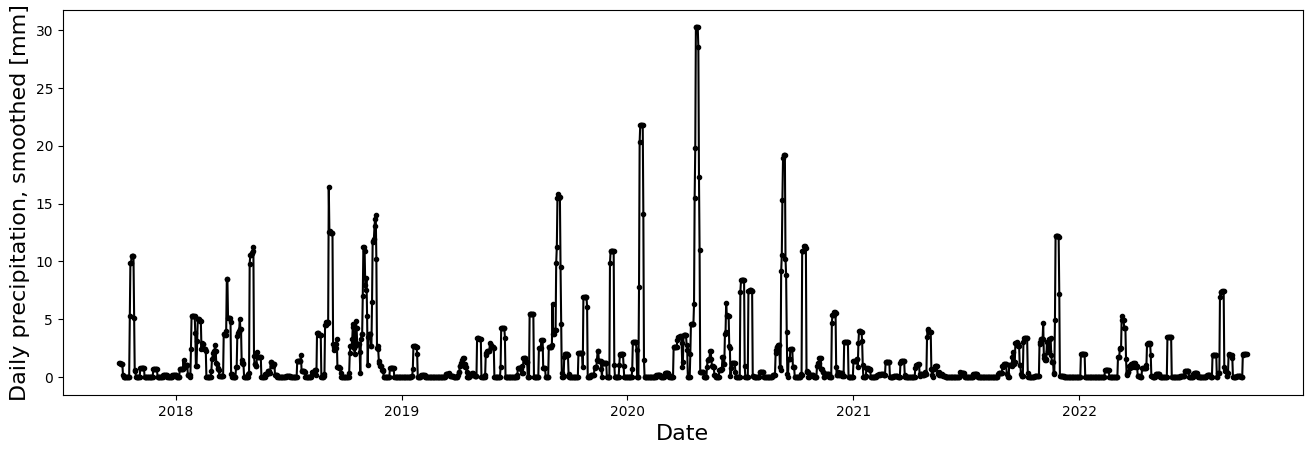

In [84]:
# LEAVE AS-IS

# Sample last 5 years
weather_smoothed_sample = weather_smoothed.tail(5*365)

# Plot smoothed temperature
plot_min_avg_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

# Plot smoothed precipitation
plot(weather_smoothed_sample, "rainfall", ylabel="Daily precipitation, smoothed [mm]")

**Key difficulties when implementing a function for "moving_average"**

One significant challenge arises from the variability in precipitation patterns over the years. This variability poses a difficulty in achieving a smooth plot that effectively highlights the underlying seasonality. Unlike temperature, where a straightforward averaging process suffices to produce a clear representation of seasonality, precipitation's inconsistency demands more nuanced techniques for achieving a visually coherent depiction.

##  Smoothed daily temperature and smoothed daily precipitation in the test dataset.

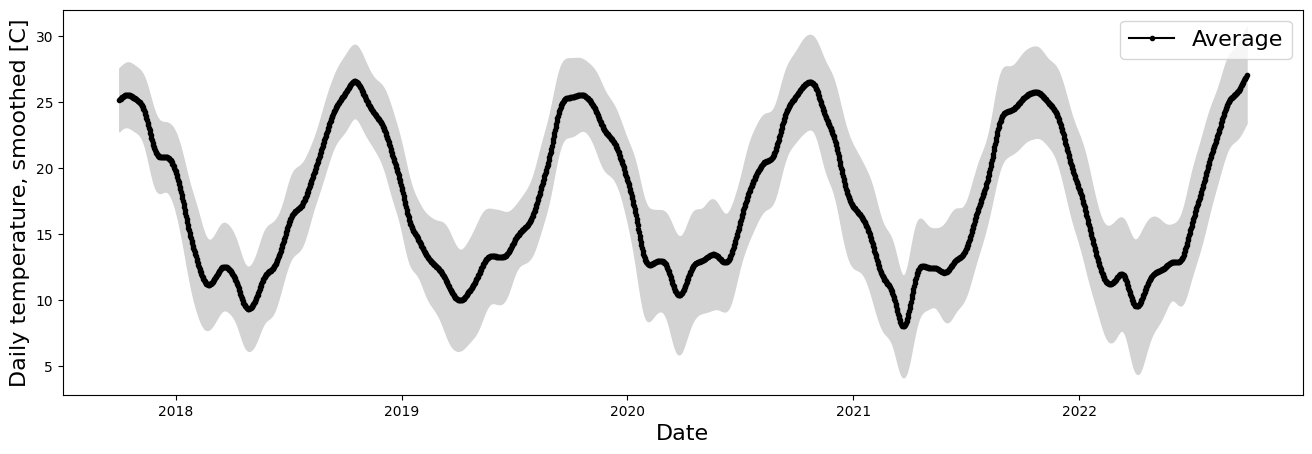

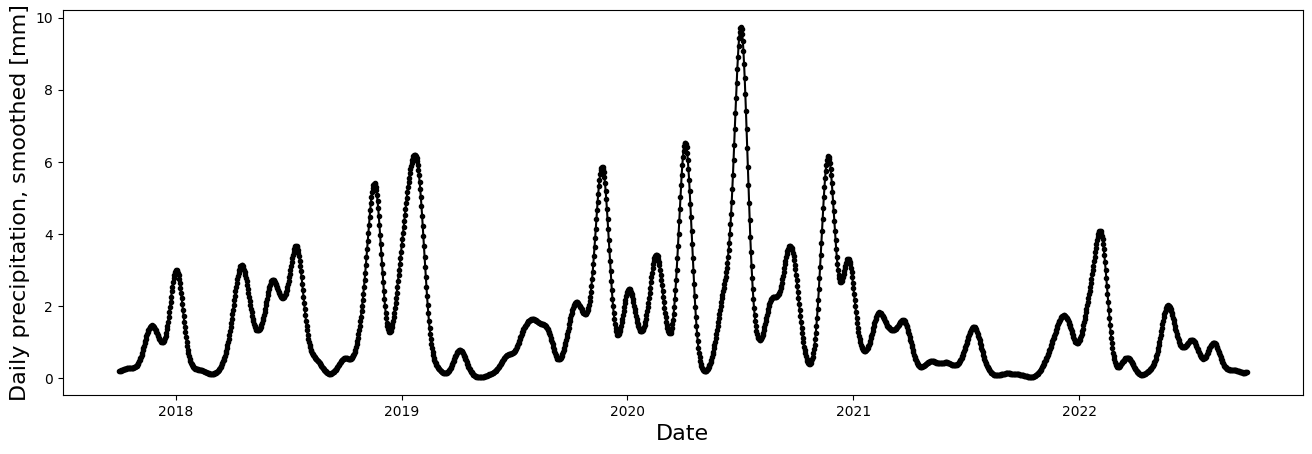

In [85]:
test = weather.copy()

for i in range(25):
    #Call the smoothing function 25 times.
    test = moving_average(test, window_size)


# Sample last 5 years
test_sample = test.tail(5*365)

# Plot smoothed temperature
plot_min_avg_max(test_sample, ylabel='Daily temperature, smoothed [C]')

# Plot smoothed precipitation
plot(test_sample, "rainfall", ylabel="Daily precipitation, smoothed [mm]")

**Why does this happen?**

The consistent temperature levels make it easy to discern the seasonality. However, when it comes to precipitation, the patterns are more gradual, and, in my view, the seasonality isn't as readily apparent for the same reasons mentioned earlier. Although now, a majority of the precipitation occurs at the beginning or end of the year, there are still instances of mid-year precipitation, as observed in 2020-2021. Despite our efforts to smooth the plot in each of the 20 iterations, the consistency in precipitation distribution remains elusive.

## 1.2. Smooth the series by binning per floating weeks

<font size="+1" color="red">Replace this cell with your code for "list_of_floating_week_starts"</font>

## List of Floating Week Starts

In [86]:
def list_of_floating_week_starts(first, last):
    weeks = []
    #Compute the weeks between the first date and the last, and for each of them:
    difference = last-first
    D = first
    for i in range(round(difference.days/7)):
        #Append to D the week and add to D one week
        weeks.append(D)
        D = D + datetime.timedelta(weeks=1)
    #Append the last one
    weeks.append(D)
    return(weeks)

In [87]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 327 week starts
First week starts 2016-07-01, last week starts 2022-09-30


In [88]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]

# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start
date,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,2016-07-01
2016-07-06,25.8,0.0,23.1,28.5,20.0,5.0,11.7,NaN,NaN,NaN,2016-07-01
2016-07-07,25.4,0.0,23.7,27.1,99.0,3.9,10.3,NaN,NaN,NaN,2016-07-01
2016-07-08,26.2,0.1,24.0,28.4,23.0,2.5,10.6,NaN,NaN,NaN,2016-07-08
2016-07-09,26.6,0.0,24.8,28.5,18.0,3.1,6.7,NaN,NaN,NaN,2016-07-08


## Generating weather per floating week df

In [89]:
#Group the temperature by weeks and compute the mean of each week.
weather_per_floating_week = weather_with_week_start.groupby('week_start')[['temp_avg', 'temp_min', 'temp_max']].mean()
#Then add the summ of the rain_fall in each week
weather_per_floating_week = weather_per_floating_week.join(weather_with_week_start.groupby('week_start')['rainfall'].sum())
display(weather_per_floating_week)

,temp_avg,temp_min,temp_max,rainfall
week_start,,,,
2016-07-01,24.628571,22.557143,26.728571,0.0
2016-07-08,25.314286,23.128571,27.500000,0.4
2016-07-15,24.171429,21.485714,26.871429,0.6
2016-07-22,25.428571,22.542857,28.328571,5.8
2016-07-29,25.957143,24.028571,27.871429,0.6
...,...,...,...,...
2022-08-26,26.328571,21.814286,30.900000,13.4
2022-09-02,26.571429,23.028571,30.100000,0.0
2022-09-09,26.242857,22.485714,29.971429,0.8


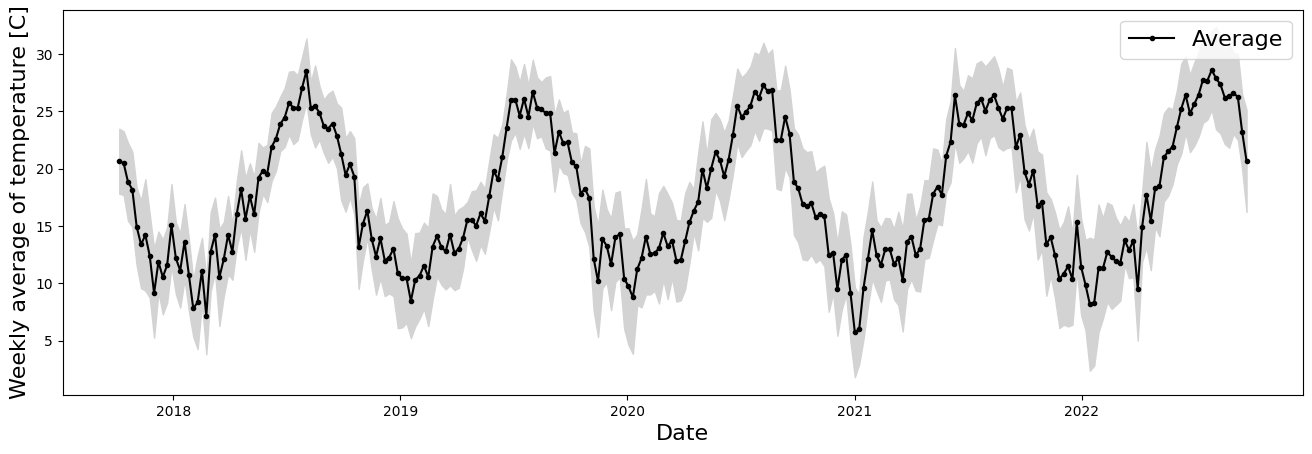

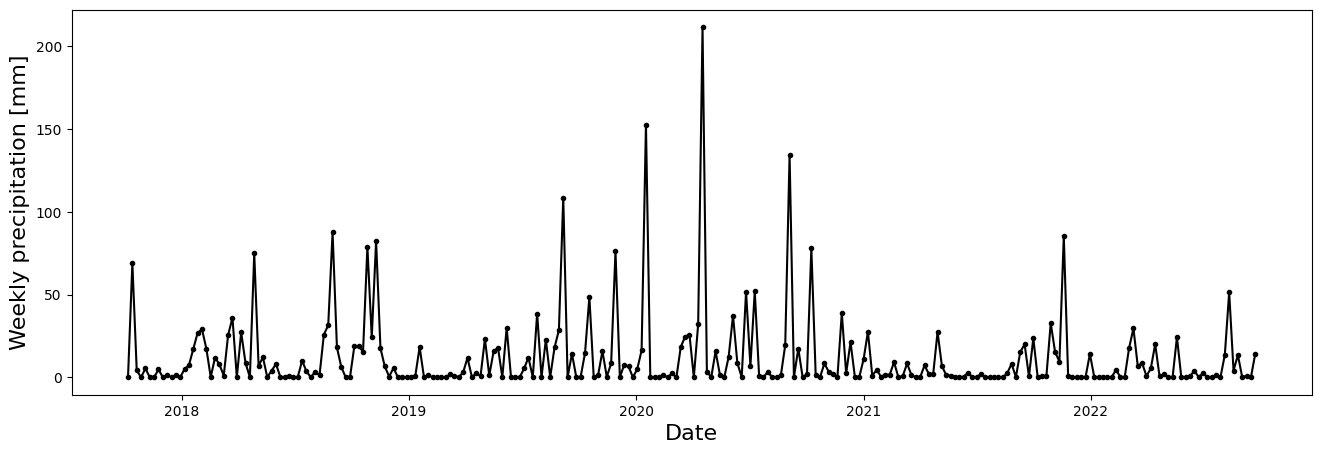

In [90]:
# LEAVE AS-IS

# Retrieve the past 5 years
weather_sample = weather_per_floating_week.tail(5*52)

# Plot temperature
plot_min_avg_max(weather_sample, ylabel="Weekly average of temperature [C]")

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Weekly precipitation [mm]")

Building upon the recent comments, a consistent observation persists in the current plots, mirroring those of previous iterations. In the temperature graph, the seasonal variations remain distinct, allowing us to discern the time of year with notable clarity, obviating the need to reference the x-axis. While the precipitation chart exhibits improved smoothness, there are still instances of irregularities, particularly in precipitation patterns at the commencement and conclusion of a year. However, treating the anomalous summer of 2020-2021 as an exception, the subsequent precipitation data aligns more closely with expected patterns.

## 1.3. Smooth the series by binning per month

## List of month Starts

In [91]:
def list_of_month_starts(first, last):
    #The same way I did with weeks, i compute the number of months between first date and last and for each of them:
    months = []
    difference = last-first
    D = first
    D = D.replace(day=1)
    for i in range(round(difference.days/30)):
        #If we're in first 11 months, we're on the same year and just add a month on D
        months.append(D)
        if D.month < 12:
            D = D.replace(month = D.month+1)
        #If we're in the last month, append 1 year and month = 1.
        elif D.month == 12:
            D = D.replace(year = D.year+1, month = 1)


    return(months)

In [92]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 76 month starts
First month starts 2016-07-01, last month starts 2022-10-01


In [93]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]

# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start,month_start
date,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,2016-07-01,2016-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-25,20.0,0.0,16.4,23.7,1.0,4.2,8.9,5.9,1013.3,1011.5,2022-09-23,2022-09-01
2022-09-26,20.3,0.0,15.0,25.6,25.0,5.6,13.3,9.7,1012.7,1009.7,2022-09-23,2022-09-01
2022-09-27,20.0,0.0,15.3,24.7,35.0,3.3,8.9,8.2,1011.5,1008.8,2022-09-23,2022-09-01


## Weather per month df

In [94]:
#Group the temperature by months and compute the mean of each month.
weather_per_month = weather_with_month_start.groupby('month_start')[['temp_avg', 'temp_min', 'temp_max']].mean()
#Add the sum of the rainfall by each month.
weather_per_month = weather_per_month.join(weather_with_month_start.groupby('month_start')['rainfall'].sum())
display(weather_per_month)

,temp_avg,temp_min,temp_max,rainfall
month_start,,,,
2016-07-01,24.996774,22.593548,27.412903,7.4
2016-08-01,24.974074,22.633333,27.318519,8.1
2016-09-01,23.703448,20.758621,26.655172,31.6
2016-10-01,19.365517,16.903448,21.837931,126.7
2016-11-01,15.027586,11.937931,18.100000,31.8
...,...,...,...,...
2022-05-01,20.482143,16.635714,24.307143,26.2
2022-06-01,24.770000,21.336667,28.200000,4.5
2022-07-01,26.974194,23.377419,30.590323,3.7


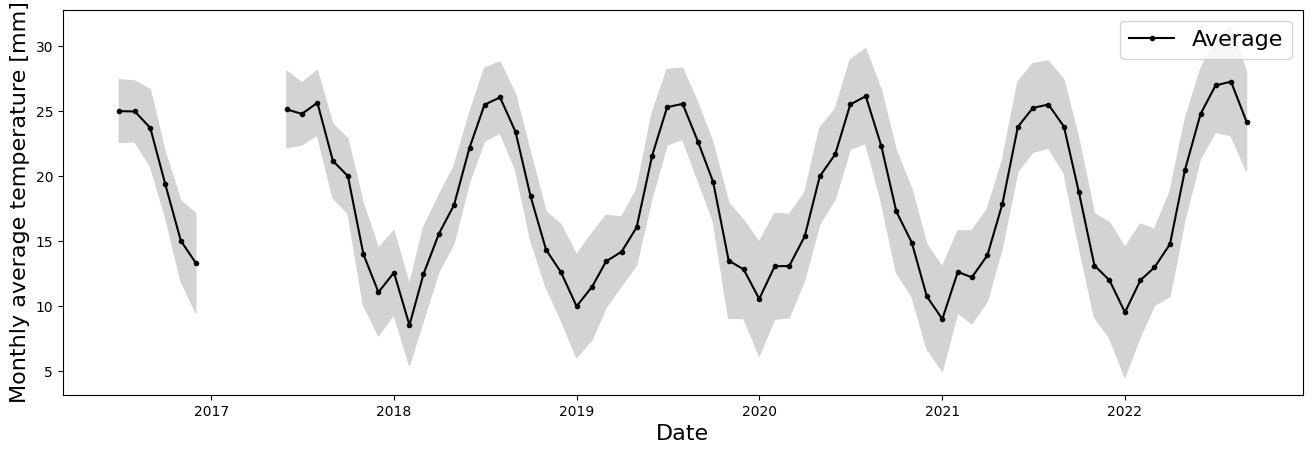

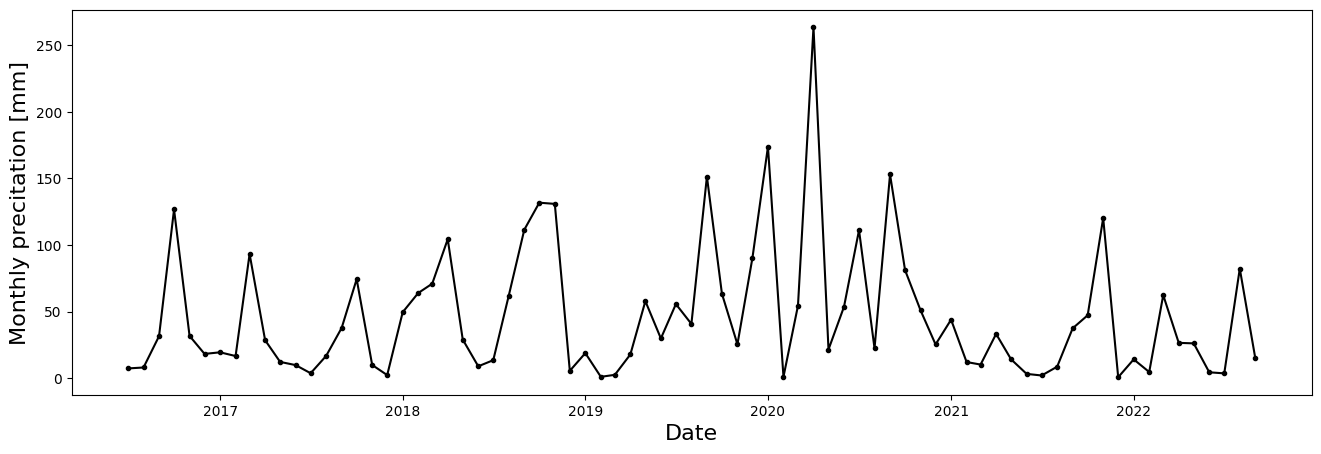

In [95]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather_per_month.tail(7*12)

# Plot temperature
plot_min_avg_max(weather_sample, ylabel="Monthly average temperature [mm]")

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Monthly precitation [mm]")

In this scenario, identifying a clear pattern in precipitation proves challenging due to the limited data points (only 12 per year). Distinguishing between the 4 to 5 summer months and the remaining ones becomes more difficult. For instance, in 2021, there was no noticeable precipitation at the beginning of the year, but when examining weekly data on the final plot, a slightly higher amount was observed. This disparity arises because the data granularity shifts from monthly to weekly observations.

# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

## Lagged Series

In [96]:
def lagged_series(series, lag):
    original_trimmed = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        if j >= 0 and j < len(series):
            # For each lag, we add to the original, the original value and to the lagged, the value j times ago.
            original_trimmed.append(series[i])
            lagged.append(series[j])
    return original_trimmed, lagged


In [97]:
# LEAVE AS-IS

assert ([44, 55, 66, 77, 88], [11, 22, 33, 44, 55]) == lagged_series([11,22,33,44,55,66,77,88], 3)

assert ([33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66]) == lagged_series([11,22,33,44,55,66,77,88], 2)

assert ([22, 33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66, 77]) == lagged_series([11,22,33,44,55,66,77,88], 1)


## Correlations

In [98]:
# LEAVE AS-IS

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)

    return correlation_without_nan(x,y)

In [99]:
def compute_autocorrelations(series, max_periods):
    autocorr = []
    for i in range(max_periods):
        autocorr.append(autocorrelation(series, i))
    return autocorr

In [100]:
max_periods = 2*365
#Compute autocorrelations of temp_avg, temp_max and rainfall for 2 years.
auto_correlations_temp = compute_autocorrelations(weather['temp_avg'], max_periods)
auto_correlations_temp_max = compute_autocorrelations(weather['temp_max'], max_periods)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], max_periods)


## Plot Correlations

In [101]:
# LEAVE AS-IS

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

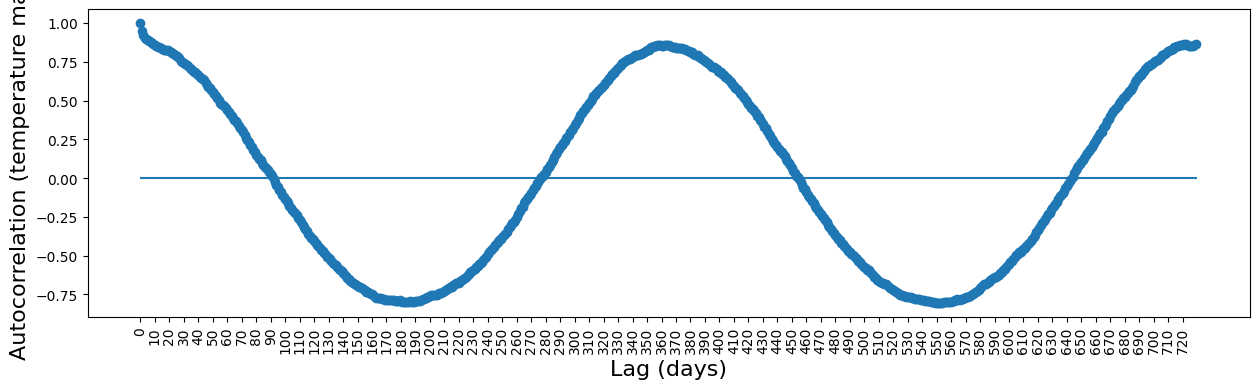

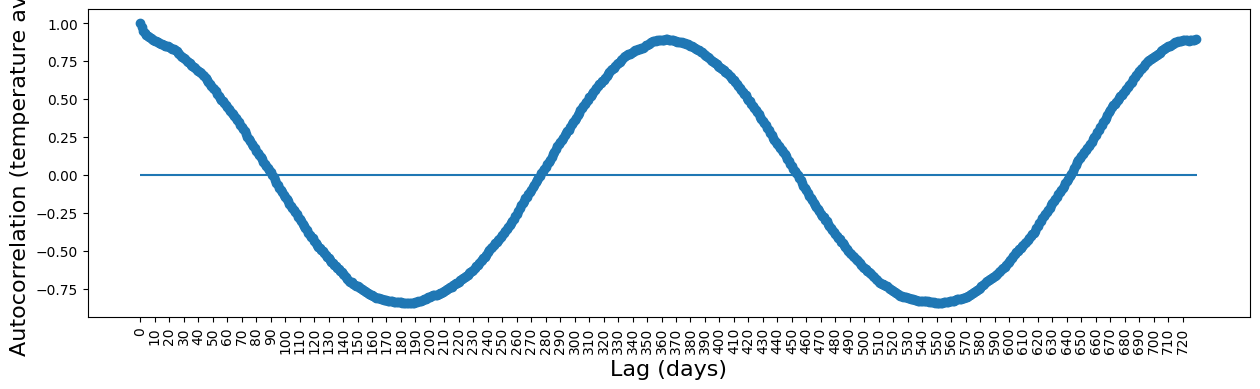

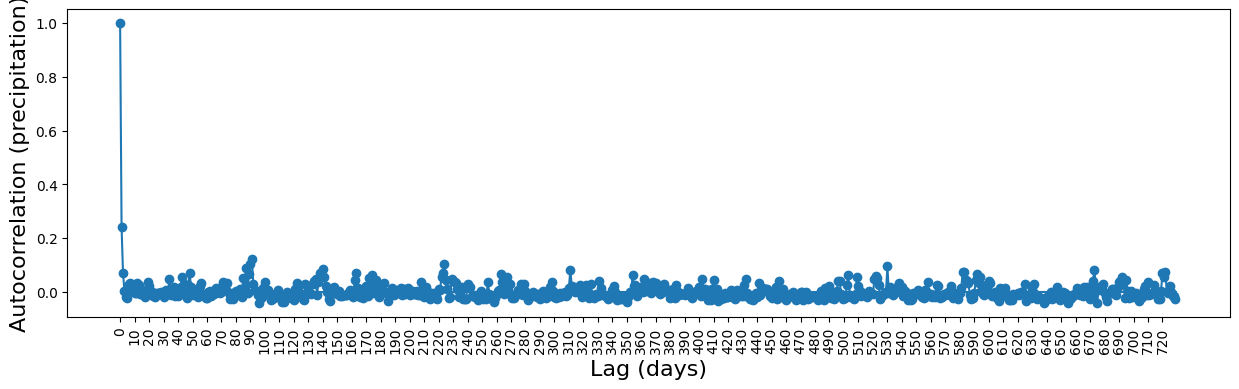

In [102]:
# LEAVE AS-IS

# Plot max temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_max, ylabel="Autocorrelation (temperature max)")

# Plot avg temperature auto-correlation
plot_auto_correlations(auto_correlations_temp, ylabel="Autocorrelation (temperature avg)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

**Do you think these correlations reflect something real about the underlying data, or are spurious?**

When examining temperature trends, a discernible pattern emerges, making predictions relatively straightforward by leveraging autocorrelation. However, predicting precipitation proves to be a formidable challenge due to its apparent lack of pattern, consistently yielding autocorrelation values near zero each month.

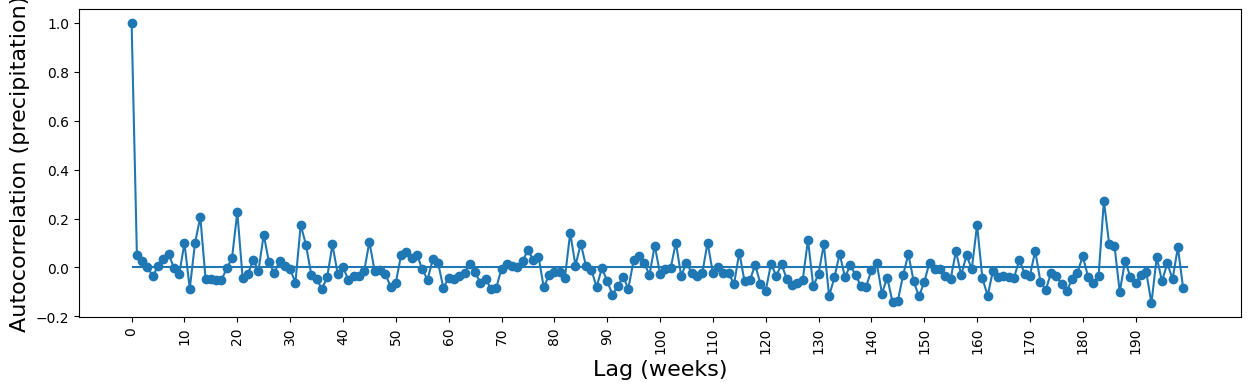

In [103]:
# LEAVE AS-IS

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

**Do you think the correlations you observe in the weekly time series of precipitation (aside from the one at lag=1) come from a real dependency, or are spurious?**

We now observe a subtle increase in variation within the autocorrelation; however, in my perspective, it doesn't appear substantial enough to be indicative of a genuine dependency. I would anticipate a legitimate dependency to manifest with an autocorrelation closer to 0.5 or -0.5. In the current context, the maximum and minimum values are aproximately at 0.2 and -0.2, respectively.

## 2.2. Prepare a system of equations to learn an auto-regressive model

## Prepare Matrices

In [104]:
def prepare_matrices(series, lags):
    y = []
    X = []

    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))

    for i in range(np.max(lags), len(series)):
        row = []
        for lag in lags:
            row.append(series[i-lag])
        if np.isnan(row).any() == False and np.isnan(series[i]) == False:
            X.append(row)
            y.append(series[i])

    return X, y

In [105]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]


In [106]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 19, 32, np.nan, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 19], [58, 51]]
y=[51, 81]


## 2.3. Perform forecasts

In [107]:
# LEAVE AS-IS

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))

    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))

    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='magenta', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

##Lags Monthly temperature

In [108]:
lags_monthly_temperature = [1, 7, 12, 20]

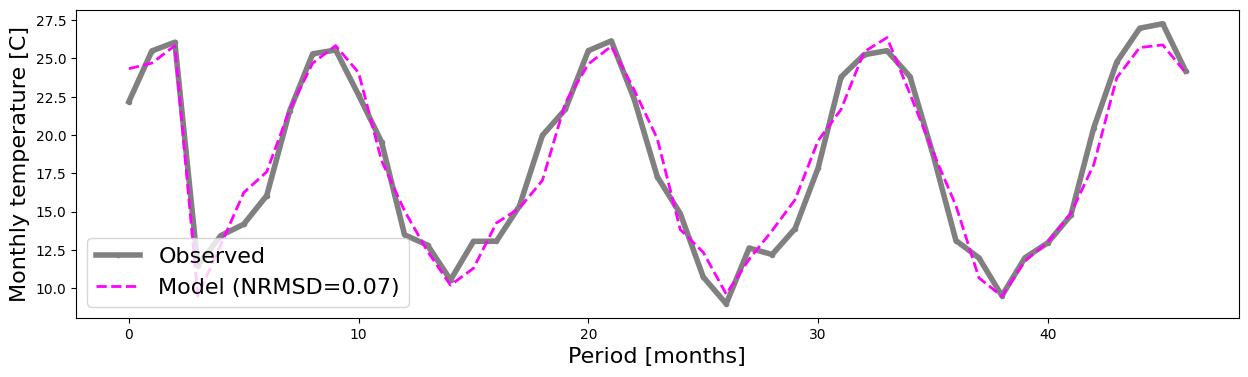

In [109]:
# LEAVE AS-IS

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly temperature [C]", nrmsd=nrmsd)

## Weekly Temperature

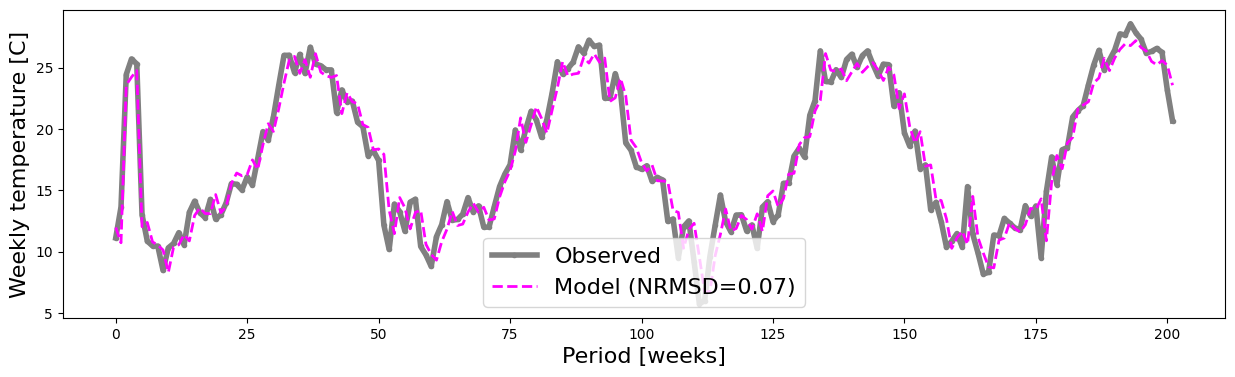

In [110]:
lags_weekly_temperature = [1,25, 55, 80]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'], lags_weekly_temperature)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)


## Daily Temperature

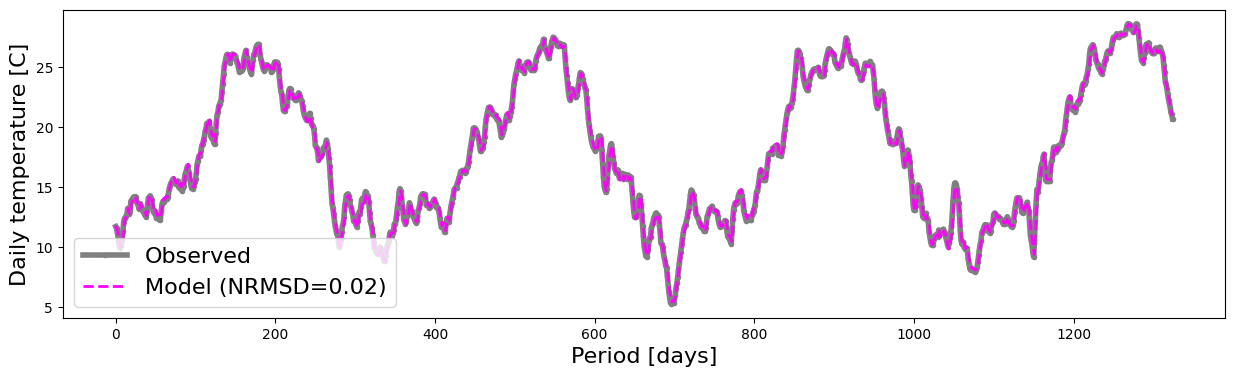

In [111]:
lags_daily_temperature = [1, 150, 350, 500]
(y, y_pred, nrmsd) = perform_forecast(weather_smoothed_sample['temp_avg'], lags_daily_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd)


Analyzing the autocorrelation plot revealed readily identifiable lags that closely aligned the model with the observed data. Consequently, we achieved an impressively low NRMSD of 0.02 for daily predictions, a minute margin that brings us remarkably close to accurately forecasting events. Achieving such precision borders on the seemingly impossible, underlining the effectiveness of our model.

## Monthly Rainfall

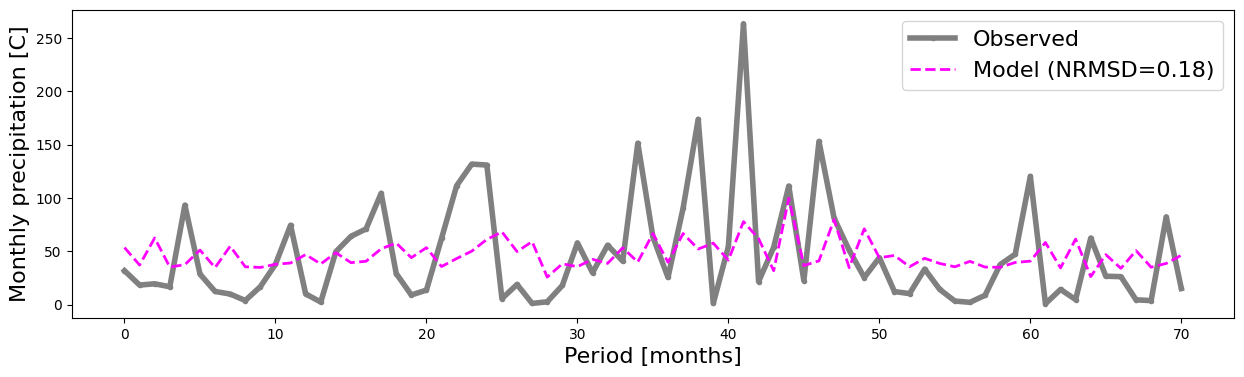

In [112]:
lags_monthly_rainfall = [1,2,3,4]
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['rainfall'], lags_monthly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly precipitation [C]", nrmsd=nrmsd)

## Weekly Rainfall

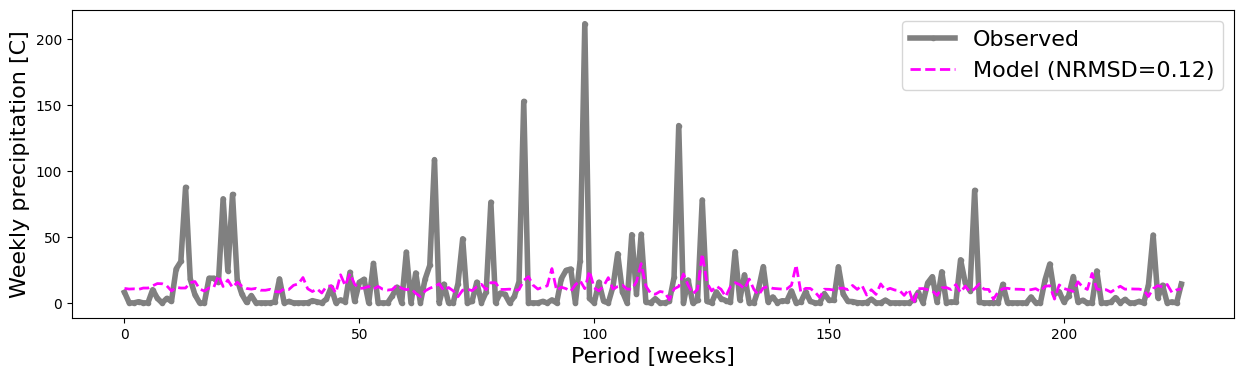

In [113]:
lags_weekly_rainfall = [1,25,50,100]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['rainfall'], lags_weekly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly precipitation [C]", nrmsd=nrmsd)


##Daily Rainfall

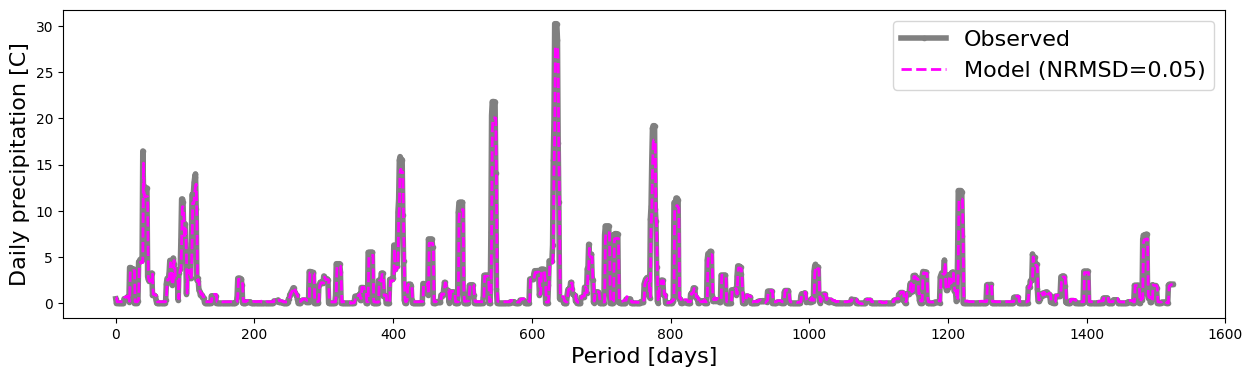

In [114]:
lags_daily_rainfall = [1,100,200,300]
(y, y_pred, nrmsd) = perform_forecast(weather_smoothed_sample['rainfall'], lags_daily_rainfall)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily precipitation [C]", nrmsd=nrmsd)

In this particular scenario, attempts to forecast weekly or monthly precipitation patterns based on historical data proved challenging despite exhaustive exploration of various time lags. Consequently, predicting next-day outcomes solely from the preceding week or month became an intricate task. The most optimal results achieved were a Normalized Root Mean Square Deviation (NRMSD) of 0.18 for monthly predictions and 0.12 for weekly predictions.

Conversely, in the case of daily precipitation forecasts, I devised a logic that revolves around analyzing the patterns of the preceding days. This approach yielded a notably favorable model, achieving an impressive NRMSD of 0.05, signifying a high level of predictive accuracy.

# <font color="blue">  EXTRA:Model for temperature that uses cross-correlations.</font>


For the extra section, I built a model that prepares lagged features for temperature variables, rainfall, and windspeed, then calculates cross-correlations to select the most relevant lagged features for predicting daily average temperature (temp_avg). It employs scikit-learn's Linear Regression model to train on these selected features and evaluates its performance on a test set using the normalized root mean squared error. The resulting model is then used to make predictions, and a plot is generated to compare the observed and predicted values, showcasing the model's ability to forecast temperature based on past weather conditions and cross-correlations between features. Adjusting the lags and exploring different models or hyperparameters could further enhance predictive accuracy.

Normalized Root Mean Squared Error : 0.05535515865462545


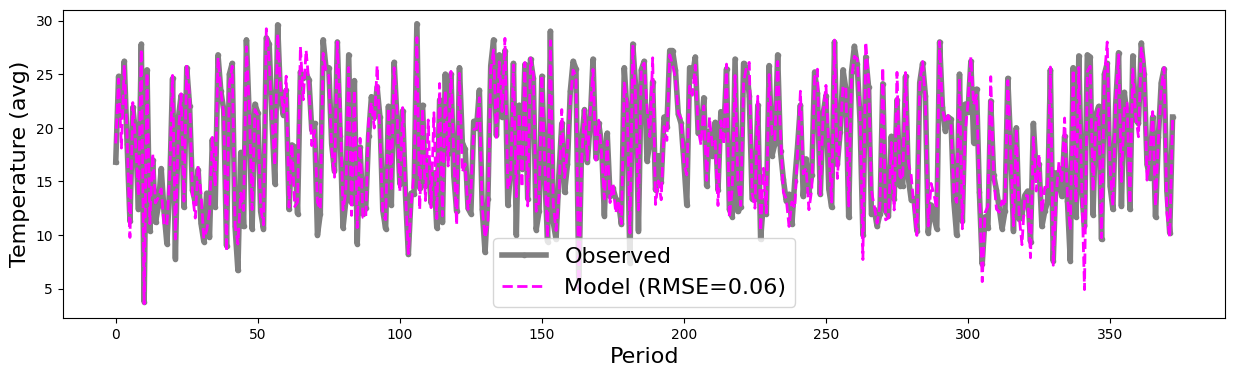

In [115]:
lags = [1, 2, 3, 4, 5, 6]  # Use lags up to the previous day

# Prepare the data
data = pd.DataFrame()
for col in ['temp_min', 'temp_avg', 'temp_max', 'rainfall', 'windspeed_avg', 'windspeed_gusts']:
    for lag in lags:
        data[f'{col}_lag_{lag}'] = weather[col].shift(lag)

data['temp_avg'] = weather['temp_avg']

# Drop rows with NaN values resulting from the lag operation
data = data.dropna()

# Calculate cross-correlations
cross_corrs = data.corr()['temp_avg'].sort_values(ascending=False)

# Select the top features based on cross-correlation
top_features = cross_corrs.index[1:]  # Exclude 'temp_avg' itself
X = data[top_features]
y = data['temp_avg']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / (np.max(y_test) - np.min(y_test))
print(f"Normalized Root Mean Squared Error : {rmse}")

# Plot observed vs. predicted values
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, '.-', linewidth=4, color='gray', label='Observed')
plt.plot(y_pred, '--', linewidth=2, color='magenta', label=f'Model (RMSE={rmse:.2f})')
plt.xlabel("Period")
plt.ylabel("Temperature (avg)")
plt.legend()
plt.show()


The normalized root mean squared error (NRMSE) of approximately 0.055 suggests that the model's predictions deviate, on average, by around 5.54% of the range between the maximum and minimum values of the observed temperature in the test set. A lower normalized RMSE indicates better predictive accuracy, and in this case, the model performs impressionability well.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>